In [2]:
import numpy as np
import torch
import gymnasium as gym
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from torch.utils import tensorboard

import sys
sys.path.insert(0, "Code/src/")

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


from environment import *

In [3]:
# helper function to convert numpy arrays to tensors
def t(x): return torch.from_numpy(x).float()

In [4]:
def mish(input):
    return input * torch.tanh(F.softplus(input))

class Mish(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, input): return mish(input)

In [5]:
class Actor(nn.Module):
    def __init__(self, state_dim, n_actions, activation=nn.Tanh):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 64),
            activation(),
            nn.Linear(64, 32),
            activation(),
            nn.Linear(32, n_actions),
            nn.Softmax()
        )
    
    def forward(self, X):
        return self.model(X)

In [6]:
# Critic module
class Critic(nn.Module):
    def __init__(self, state_dim, activation=nn.Tanh):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 64),
            activation(),
            nn.Linear(64, 32),
            activation(),
            nn.Linear(32, 1)
        )
    
    def forward(self, X):
        return self.model(X)

In [7]:
env = gym.make("CartPole-v1")

In [8]:
# config
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n
actor = Actor(state_dim, n_actions, activation=Mish)
critic = Critic(state_dim, activation=Mish)
adam_actor = torch.optim.Adam(actor.parameters(), lr=3e-4)
adam_critic = torch.optim.Adam(critic.parameters(), lr=1e-3)

torch.manual_seed(1)

In [9]:
def clip_grad_norm_(module, max_grad_norm):
    nn.utils.clip_grad_norm_([p for g in module.param_groups for p in g["params"]], max_grad_norm)

def policy_loss(old_log_prob, log_prob, advantage, eps):
    ratio = (log_prob - old_log_prob).exp()
    clipped = torch.clamp(ratio, 1-eps, 1+eps)*advantage
    
    m = torch.min(ratio*advantage, clipped)
    return -m



In [25]:
episode_rewards = []
gamma = 0.98
eps = 0.2
w = tensorboard.SummaryWriter()
s = 0
max_grad_norm = 0.5

for i in range(800):
    prev_prob_act = None
    done = False
    total_reward = 0
    state,_ = env.reset()


    while not done:
        s += 1
        
        probs = actor(t(state))
        dist = torch.distributions.Categorical(probs=probs)
        action = dist.sample()
        prob_act = dist.log_prob(action)
        print(action, "ACTION")
        print(state, "STATE")

        print(action.detach().data.numpy(), "HERE")

        ret = env.step(action.detach().data.numpy())
        next_state, reward, done, info, _ = ret
        print(type(reward), "REWARD")
        print(done)
        advantage = reward + (1-done)*gamma*critic(t(next_state)) - critic(t(state))
        
        w.add_scalar("loss/advantage", advantage, global_step=s)
        w.add_scalar("actions/action_0_prob", dist.probs[0], global_step=s)
        w.add_scalar("actions/action_1_prob", dist.probs[1], global_step=s)
        
        total_reward += reward
        state = next_state
        
        if prev_prob_act:
            actor_loss = policy_loss(prev_prob_act.detach(), prob_act, advantage.detach(), eps)
            w.add_scalar("loss/actor_loss", actor_loss, global_step=s)
            adam_actor.zero_grad()
            actor_loss.backward()
            # clip_grad_norm_(adam_actor, max_grad_norm)
            w.add_histogram("gradients/actor",
                             torch.cat([p.grad.view(-1) for p in actor.parameters()]), global_step=s)
            adam_actor.step()

            critic_loss = advantage.pow(2).mean()
            w.add_scalar("loss/critic_loss", critic_loss, global_step=s)
            adam_critic.zero_grad()
            critic_loss.backward()
            # clip_grad_norm_(adam_critic, max_grad_norm)
            w.add_histogram("gradients/critic",
                             torch.cat([p.data.view(-1) for p in critic.parameters()]), global_step=s)
            adam_critic.step()
        
        prev_prob_act = prob_act
    
    w.add_scalar("reward/episode_reward", total_reward, global_step=i)
    episode_rewards.append(total_reward)

c:\Users\sebge\miniconda3\envs\shs-philo\lib\site-packages\torch\nn\modules\module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor(0) ACTION
[-0.01419203  0.01035251  0.02388573  0.02206156] STATE
0 HERE
<class 'float'> REWARD
False
tensor(0) ACTION
[-0.01398498 -0.1851037   0.02432696  0.32218397] STATE
0 HERE
<class 'float'> REWARD
False
tensor(0) ACTION
[-0.01768705 -0.38056347  0.03077064  0.6224383 ] STATE
0 HERE
<class 'float'> REWARD
False
tensor(0) ACTION
[-0.02529832 -0.57610124  0.04321941  0.92465127] STATE
0 HERE
<class 'float'> REWARD
False
tensor(1) ACTION
[-0.03682035 -0.7717795   0.06171243  1.2305971 ] STATE
1 HERE
<class 'float'> REWARD
False
tensor(0) ACTION
[-0.05225594 -0.5775033   0.08632437  0.95786947] STATE
0 HERE
<class 'float'> REWARD
False
tensor(0) ACTION
[-0.063806   -0.77367324  0.10548177  1.2763766 ] STATE
0 HERE
<class 'float'> REWARD
False
tensor(0) ACTION
[-0.07927947 -0.9699702   0.1310093   1.6001396 ] STATE
0 HERE
<class 'float'> REWARD
False
tensor(0) ACTION
[-0.09867887 -1.166378    0.16301209  1.9306333 ] STATE
0 HERE
<class 'float'> REWARD
False
tensor(1) ACTION
[-

KeyboardInterrupt: 

In [10]:
## PPO for gridworld environment

#svf_exp += self.env.gamma**step * self.env.get_svf_features(state=self.state)
#rewards += self.env.gamma**step * self.env.get_rewards(state=self.state)
#self.state = self.env.take_action(self.state, a)

gridworld = GridWorldEnvironment(0, 10, prop=0)

# config
state_dim = gridworld.n_states
n_actions = gridworld.n_actions
actor = Actor(state_dim, n_actions, activation=Mish)
critic = Critic(state_dim, activation=Mish)
adam_actor = torch.optim.Adam(actor.parameters(), lr=3e-4)
adam_critic = torch.optim.Adam(critic.parameters(), lr=1e-3)

torch.manual_seed(1)

In [11]:
episode_rewards = []
gamma = 0.98
eps = 0.2
w = tensorboard.SummaryWriter()
s = 0
max_grad_norm = 0.5

for i in range(600):
    prev_prob_act = None
    done = False
    total_reward = 0
    #state = env.reset()
    
    state_id = gridworld.get_random_initial_state()
    state = gridworld.get_svf_features(state=state_id)

    while not done:
        s += 1
        probs = actor(t(state))
        dist = torch.distributions.Categorical(probs=probs)
        action = dist.sample()
        prob_act = dist.log_prob(action)
        #print(action.detach().numpy(), "ACTION")
        #print(state_id, "STATE")
        #next_state, reward, done, info = env.step(action.detach().data.numpy())
        next_state_id = gridworld.take_action(state_id, int(action.detach().numpy()))
        next_state = gridworld.get_svf_features(state=next_state_id)
        reward = gridworld.get_rewards(state=state_id)
        done = (state_id == [0, 0]).all()
        if done:
            print(done, "DONE")
        #print(type(float(reward)), "REWARD")
        #print(torch.FloatTensor(np.array(reward)) )
        #print(critic(t(state)), "CRITIC STATE")
        #print(critic(t(next_state)), "CRITIC NEXT STATE")
        #print((1-done)*gamma*critic(t(next_state)) - critic(t(state)))
        advantage = float(reward) + (1-done)*gamma*critic(t(next_state)) - critic(t(state))
        #print(advantage, "ADVANTAGE")
        w.add_scalar("loss/advantage", advantage, global_step=s)
        w.add_scalar("actions/action_0_prob", dist.probs[0], global_step=s)
        w.add_scalar("actions/action_1_prob", dist.probs[1], global_step=s)
        w.add_scalar("actions/action_2_prob", dist.probs[2], global_step=s)
        w.add_scalar("actions/action_3_prob", dist.probs[3], global_step=s)
        total_reward += reward
        state = next_state
        state_id = next_state_id
        
        if prev_prob_act:
            actor_loss = policy_loss(prev_prob_act.detach(), prob_act, advantage.detach(), eps)
            w.add_scalar("loss/actor_loss", actor_loss, global_step=s)
            adam_actor.zero_grad()
            actor_loss.backward()
            # clip_grad_norm_(adam_actor, max_grad_norm)
            w.add_histogram("gradients/actor",
                             torch.cat([p.grad.view(-1) for p in actor.parameters()]), global_step=s)
            adam_actor.step()

            critic_loss = advantage.pow(2).mean()
            w.add_scalar("loss/critic_loss", critic_loss, global_step=s)
            adam_critic.zero_grad()
            critic_loss.backward()
            # clip_grad_norm_(adam_critic, max_grad_norm)
            w.add_histogram("gradients/critic",
                             torch.cat([p.data.view(-1) for p in critic.parameters()]), global_step=s)
            adam_critic.step()
        
        prev_prob_act = prob_act
    
    w.add_scalar("reward/episode_reward", total_reward, global_step=i)
    episode_rewards.append(total_reward)

c:\Users\sebge\miniconda3\envs\shs-philo\lib\site-packages\torch\nn\modules\module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE
True DONE


In [12]:
gridworld.take_action(9, 2)

9

In [13]:
s

56579

In [14]:
w

In [15]:
episode_rewards

[np.float64(-707.0),
 np.float64(-62.0),
 np.float64(-294.0),
 np.float64(-202.0),
 np.float64(-732.0),
 np.float64(-114.0),
 np.float64(-1651.0),
 np.float64(-522.0),
 np.float64(-396.0),
 np.float64(-255.0),
 np.float64(-329.0),
 np.float64(-656.0),
 np.float64(-148.0),
 np.float64(-38.0),
 np.float64(-6.0),
 np.float64(-132.0),
 np.float64(-754.0),
 np.float64(-746.0),
 np.float64(-156.0),
 np.float64(-212.0),
 np.float64(-246.0),
 np.float64(-55.0),
 np.float64(-195.0),
 np.float64(-81.0),
 np.float64(-83.0),
 np.float64(-350.0),
 np.float64(-350.0),
 np.float64(-649.0),
 np.float64(-224.0),
 np.float64(-254.0),
 np.float64(-13.0),
 np.float64(-134.0),
 np.float64(-229.0),
 np.float64(-479.0),
 np.float64(-133.0),
 np.float64(-107.0),
 np.float64(-409.0),
 np.float64(-228.0),
 np.float64(-208.0),
 np.float64(-43.0),
 np.float64(-636.0),
 np.float64(-154.0),
 np.float64(-340.0),
 np.float64(-167.0),
 np.float64(-137.0),
 np.float64(-29.0),
 np.float64(-20.0),
 np.float64(-101.0),
 n

In [16]:
gridworld.take_action([4,4], 0)

array([3, 4])

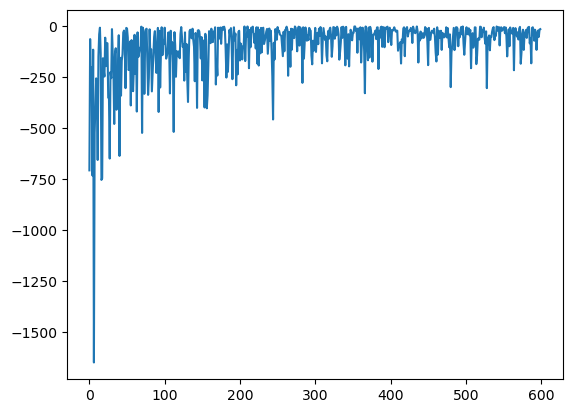

In [17]:
plt.plot(episode_rewards)